In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Loading movie ratings dataset.

Average rating for movie 1 (Toy Story): 3.878319 / 5



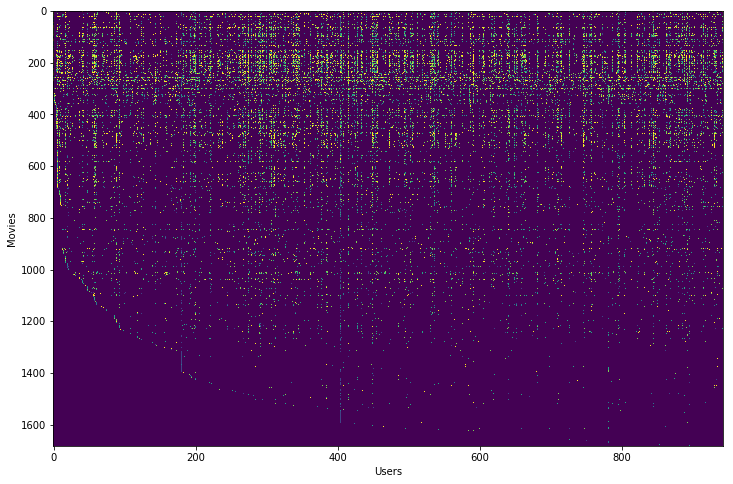

In [2]:
## =============== Part 1: Loading movie ratings dataset ================
#  You will start by loading the movie ratings dataset to understand the
#  structure of the data.
#  
print('Loading movie ratings dataset.\n')

#  Load data
mat = scipy.io.loadmat('data/ex8/ex8_movies.mat')
Y = mat["Y"]
R = mat["R"]

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): {:f} / 5\n'.format(np.mean(Y[0, R[0, :]==1])))

#  We can "visualize" the ratings matrix by plotting it with imagesc
# need aspect='auto' for a ~16:9 (vs almost vertical) aspect
plt.figure(figsize=(12,8))
plt.imshow(Y, aspect='auto') 
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show(block=False)

In [3]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_var):
    #COFICOSTFUNC Collaborative filtering cost function
    #   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #

    # Unfold the U and W matrices from params
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features), order='F')

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the cost function and gradient for collaborative
    #               filtering. Concretely, you should first implement the cost
    #               function (without regularization) and make sure it is
    #               matches our costs. After that, you should implement the 
    #               gradient and use the checkCostFunction routine to check
    #               that the gradient is correct. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies  x num_features matrix of movie features
    #        Theta - num_users  x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R(i, j) = 1 if the 
    #            i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly:
    #
    #        X_grad - num_movies x num_features matrix, containing the 
    #                 partial derivatives w.r.t. to each element of X
    #        Theta_grad - num_users x num_features matrix, containing the 
    #                     partial derivatives w.r.t. to each element of Theta
    #

    ### COST FUNCTION, NO REGULARIZATION

    # X * Theta performed according to low rank matrix vectorization
    squared_error = np.power(np.dot(X,Theta.T) - Y,2)

    # for cost function, sum only i,j for which R(i,j)=1
    J = (1/2.) * np.sum(squared_error * R)

    ### GRADIENTS, NO REGULARIZATION

    # X_grad is of dimensions n_m x n, where n_m = 1682 and n = 100 
    #  ( (X * Theta') - Y ) is n_m x n_u
    #  (( (X * Theta') - Y ) .* R) is still n_m x n_u 
    #  Theta is n_u x n
    #  thus X_grad = (( (X * Theta') - Y ) .* R) * Theta is n_m x n
    # NOTE where filtering through R is applied: 
    # 	at ( (X * Theta') - Y ) - NOT after multiplying by Theta 
    # 	that means that for purposes of the gradient, we're only interested
    # 	in the errors/differences in i, j for which R(i,j)=1
    # NOTE also that even though we do a sum, we only do it over users,
    # 	so we still get a matrix
    X_grad = np.dot(( np.dot(X, Theta.T) - Y ) * R, Theta)


    # Theta_grad is of dimensions n_u x n, where n_u = 943 and n = 100 
    #  ( (X * Theta') - Y ) is n_m x n_u 
    #  (( (X * Theta') - Y ) .* R) is still n_m x n_u 
    #  X is n_m x n
    #  thus Theta_grad = (( (X * Theta') - Y ) .* R)' * X is n_u x n 
    # NOTE where filtering through R is applied,
    # 	at ( (X * Theta') - Y ) - NOT after multiplying by X
    # 	that means that for purposes of the gradient, we're only interested
    # 	in the errors/differences in i, j for which R(i,j)=1
    # NOTE also that even though we do a sum, we only do it over movies,
    # 	so we still get a matrix
    Theta_grad = np.dot((( np.dot(X, Theta.T) - Y ) * R).T, X)

    ### COST FUNCTION WITH REGULARIZATION
    # only add regularized cost to J now
    J = J + (lambda_var/2.)*( np.sum( np.power(Theta, 2) ) + np.sum( np.power(X, 2) ) )

    ### GRADIENTS WITH REGULARIZATION
    # only add regularization terms
    X_grad = X_grad + lambda_var*X
    Theta_grad = Theta_grad + lambda_var*Theta

    # =============================================================

    grad = np.concatenate((X_grad.reshape(X_grad.size, order='F'), Theta_grad.reshape(Theta_grad.size, order='F')))

    return J, grad

In [5]:
## ============ Part 2: Collaborative Filtering Cost Function ===========
#  You will now implement the cost function for collaborative filtering.
#  To help you debug your cost function, we have included set of weights
#  that we trained on that. Specifically, you should complete the code in 
#  cofiCostFunc.m to return J.

#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
mat = scipy.io.loadmat('data/ex8/ex8_movieParams.mat')
X = mat["X"]
Theta = mat["Theta"]
num_users = mat["num_users"]
num_movies = mat["num_movies"]
num_features = mat["num_features"]

#  Reduce the data set size so that this runs faster
num_users = 4 
num_movies = 5 
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

#  Evaluate cost function
params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))
J, _ = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
           
print('Cost at loaded parameters: {:f}\n(this value should be about 22.22)\n'.format(J))

Cost at loaded parameters: 22.224604
(this value should be about 22.22)



In [8]:
def computeNumericalGradient(J, theta):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and 
    #        returns the numerical gradient.It sets numgrad(i) to (a numerical 
    #        approximation of) the partial derivative of J with respect to the 
    #        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    #        be the (approximately) the partial derivative of J with respect 
    #        to theta(i).)
    #                

    numgrad = np.zeros( theta.shape )
    perturb = np.zeros( theta.shape )
    e = 1e-4

    for p in range(theta.size):
        # Set perturbation vector
        perturb.reshape(perturb.size, order="F")[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad.reshape(numgrad.size, order="F")[p] = (loss2 - loss1) / (2*e)
        perturb.reshape(perturb.size, order="F")[p] = 0

    return numgrad
def checkCostFunction(lambda_var=0):
    #CHECKCOSTFUNCTION Creates a collaborative filering problem 
    #to check your cost function and gradients
    #   CHECKCOSTFUNCTION(lambda_var) Creates a collaborative filering problem 
    #   to check your cost function and gradients, it will output the 
    #   analytical gradients produced by your code and the numerical gradients 
    #   (computed using computeNumericalGradient). These two gradient 
    #   computations should result in very similar values.

    # Set lambda_var
    # if not lambda_var or not 'lambda_var' in locals():
    #     lambda_var = 0

    ## Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    ## Run Gradient Checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]

    params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

    # Short hand for cost function
    def costFunc(p):
        return cofiCostFunc(p, Y, R, num_users, num_movies, num_features, lambda_var)

    numgrad = computeNumericalGradient(costFunc, params)

    cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_var)


    print(np.column_stack((numgrad, grad)))
    print('The above two columns you get should be very similar.\n' \
             '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). ' \
             '\nRelative Difference: {:e}'.format(diff))



In [9]:
## ============== Part 3: Collaborative Filtering Gradient ==============
#  Once your cost function matches up with ours, you should now implement 
#  the collaborative filtering gradient function. Specifically, you should 
#  complete the code in cofiCostFunc.m to return the grad argument.
#  
print('\nChecking Gradients (without regularization) ... \n')

#  Check gradients by running checkNNGradients
checkCostFunction()


Checking Gradients (without regularization) ... 

[[ -3.04636805  -3.04636805]
 [  1.80107172   1.80107172]
 [-12.67646738 -12.67646738]
 [ -2.86219693  -2.86219693]
 [  3.24777453   3.24777453]
 [  1.25444375   1.25444375]
 [-11.8000541  -11.8000541 ]
 [  4.11234557   4.11234557]
 [ -2.16605449  -2.16605449]
 [  1.3063771    1.3063771 ]
 [  5.89960066   5.89960066]
 [  0.82731672   0.82731672]
 [ -2.14412727  -2.14412727]
 [  4.27359408   4.27359408]
 [  8.07813664   8.07813664]
 [  3.16912985   3.16912985]
 [ -7.07043245  -7.07043245]
 [ -1.85712168  -1.85712168]
 [  1.91269684   1.91269684]
 [  5.10425979   5.10425979]
 [  1.04217887   1.04217887]
 [ -1.68240771  -1.68240771]
 [  4.13104372   4.13104372]
 [  2.24253922   2.24253922]
 [ -0.07494667  -0.07494667]
 [  3.39083654   3.39083654]
 [ -3.47204546  -3.47204546]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your backpropagation implementation is correct, th

In [11]:
## ========= Part 4: Collaborative Filtering Cost Regularization ========
#  Now, you should implement regularization for the cost function for 
#  collaborative filtering. You can implement it by adding the cost of
#  regularization to the original cost computation.
#  

#  Evaluate cost function
params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))
J, _ = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda_var = 1.5): {:f} '\
         '\n(this value should be about 31.34)\n'.format(J))


Cost at loaded parameters (lambda_var = 1.5): 31.344056 
(this value should be about 31.34)



In [12]:
## ======= Part 5: Collaborative Filtering Gradient Regularization ======
#  Once your cost matches up with ours, you should proceed to implement 
#  regularization for the gradient. 
#

#  
print('\nChecking Gradients (with regularization) ... \n')

#  Check gradients by running checkNNGradients
checkCostFunction(1.5)



Checking Gradients (with regularization) ... 

[[-1.48499635 -1.48499635]
 [ 0.20000708  0.20000708]
 [ 0.92617918  0.92617918]
 [-4.47610054 -4.47610054]
 [ 1.95334873  1.95334873]
 [-1.93594552 -1.93594552]
 [ 0.65335892  0.65335892]
 [ 5.43479621  5.43479621]
 [ 3.12140506  3.12140506]
 [-2.4258093  -2.4258093 ]
 [-1.32710924 -1.32710924]
 [ 3.06368184  3.06368184]
 [ 1.03804117  1.03804117]
 [ 0.71935706  0.71935706]
 [ 0.80026327  0.80026327]
 [ 2.07592839  2.07592839]
 [ 0.99233282  0.99233282]
 [-2.99182429 -2.99182429]
 [-3.02224925 -3.02224925]
 [-4.61361918 -4.61361918]
 [-3.2294597  -3.2294597 ]
 [-2.00493617 -2.00493617]
 [ 0.08262671  0.08262671]
 [ 1.37340209  1.37340209]
 [-2.49966882 -2.49966882]
 [ 0.83736801  0.83736801]
 [ 0.62863936  0.62863936]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9

In [13]:
def loadMovieList():
    #GETMOVIELIST reads the fixed movie list in movie.txt and returns a
    #cell array of the words
    #   movieList = GETMOVIELIST() reads the fixed movie list in movie.txt 
    #   and returns a cell array of the words in movieList.


    ## Read the fixed movieulary list
    with open("data/ex8/movie_ids.txt") as movie_ids_file:

        # Store all movies in movie list
        n = 1682  # Total number of movies 

        movieList = [None]*n
        for i, line in enumerate(movie_ids_file.readlines()):
            movieName = line.split()[1:]
            movieList[i] = " ".join(movieName)

    return movieList

In [14]:
## ============== Part 6: Entering ratings for a new user ===============
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
#
movieList = loadMovieList()

#  Initialize my ratings
my_ratings = np.zeros((1682, 1))

# NOTE THAT THE FOLLOWING SECTION AS WELL AS THE movie_ids.txt file
# USED HERE IS ADAPTED FOR PYTHON'S 0-INDEX (VS MATLAB/OCTAVE'S 1-INDEX)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 0, so to rate it "4", you can set
# my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
# my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[0] = 5
# my_ratings[6] = 3
my_ratings[11]= 5
# my_ratings[53] = 4
my_ratings[63]= 4
# my_ratings[65]= 3
my_ratings[68] = 3
my_ratings[97] = 4
# my_ratings[182] = 4
my_ratings[225] = 3
# my_ratings[354]= 5

print('\n\nNew user ratings:\n')
for i, rating in enumerate(my_ratings):
    if rating > 0: 
        print('Rated {:.0f} for {:s}\n'.format(rating[0], movieList[i]))





New user ratings:

Rated 5 for Toy Story (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Shawshank Redemption, The (1994)

Rated 3 for Forrest Gump (1994)

Rated 4 for Silence of the Lambs, The (1991)

Rated 3 for Die Hard 2 (1990)



In [19]:
def normalizeRatings(Y, R):
    #NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
    #movie (every row)
    #   [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
    #   has a rating of 0 on average, and returns the mean rating in Ymean.
    #

    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

In [20]:
## ================== Part 7: Learning Movie Ratings ====================
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users
#

print('\nTraining collaborative filtering...\n')

#  Load data
mat = scipy.io.loadmat('data/ex8/ex8_movies.mat')
Y = mat["Y"]
R = mat["R"]

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.column_stack((my_ratings, Y))
R = np.column_stack(((my_ratings != 0).astype(int), R))

#  Normalize Ratings
[Ynorm, Ymean] = normalizeRatings(Y, R)

#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

# Set options
maxiter = 100
options = {'disp': True, 'maxiter':maxiter}
lambda_var=10

# Create "short hand" for the cost function to be minimized
def costFunc(initial_parameters):
    return cofiCostFunc(initial_parameters, Y, R, num_users, num_movies, num_features, lambda_var)

# Set Regularization
results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)
theta = results["x"]

# Unfold the returned theta back into U and W
X = np.reshape(theta[:num_movies*num_features], (num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features), order='F')

print('Recommender system learning completed.\n')


Training collaborative filtering...

Recommender system learning completed.



In [21]:
## ================== Part 8: Recommendation for you ====================
#  After training the model, you can now make recommendations by computing
#  the predictions matrix.
#

p = np.dot(X, Theta.T)
my_predictions = p[:,0] + Ymean.flatten()

#movieList = loadMovieList()

# from http://stackoverflow.com/a/16486305/583834
# reverse sorting by index
ix = my_predictions.argsort()[::-1]

print('\n\nTop recommendations for you:\n')
for i in range(10):
    j = ix[i]
    print('Predicting rating {:.5f} for movie {:s}'.format(my_predictions[j], movieList[j]))

print('\n\nOriginal ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {:d} for {:s}'.format(int(my_ratings[i]), movieList[i]))




Top recommendations for you:

Predicting rating 7.94739 for movie Star Wars (1977)
Predicting rating 7.77270 for movie Titanic (1997)
Predicting rating 7.74689 for movie Schindler's List (1993)
Predicting rating 7.72783 for movie Shawshank Redemption, The (1994)
Predicting rating 7.61024 for movie Good Will Hunting (1997)
Predicting rating 7.58770 for movie Usual Suspects, The (1995)
Predicting rating 7.57847 for movie Raiders of the Lost Ark (1981)
Predicting rating 7.55666 for movie Godfather, The (1972)
Predicting rating 7.51289 for movie Close Shave, A (1995)
Predicting rating 7.50409 for movie Empire Strikes Back, The (1980)


Original ratings provided:
Rated 5 for Toy Story (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Shawshank Redemption, The (1994)
Rated 3 for Forrest Gump (1994)
Rated 4 for Silence of the Lambs, The (1991)
Rated 3 for Die Hard 2 (1990)
